In [ ]:
# Install Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download correct Spark version
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# Extract it
!tar -xzf spark-3.4.1-bin-hadoop3.tgz

# Install findspark and pyspark
!pip install -q findspark pyspark


In [ ]:
import os
import findspark

# Set environment variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# Initialize Spark
findspark.init()

from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder.appName("MentalHealthTweets").getOrCreate()
spark


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving mental_health_tweets_large.csv to mental_health_tweets_large.csv


In [ ]:
df = spark.read.option("header", "true").csv("mental_health_tweets_large.csv")
df.show(5, truncate=False)


+---+-------+-------------------+-----------------------------------------+
|id |user   |timestamp          |tweet_text                               |
+---+-------+-------------------+-----------------------------------------+
|1  |user_11|2023-07-21 04:08:00|I'm feeling anxious all day.             |
|2  |user_3 |2023-08-22 08:18:00|Feeling better after talking to a friend.|
|3  |user_13|2023-07-10 18:29:00|Just finished reading about anxiety.     |
|4  |user_13|2023-09-03 10:15:00|Feeling really down and disconnected.    |
|5  |user_7 |2023-07-09 13:49:00|Therapy is helping me improve day by day.|
+---+-------+-------------------+-----------------------------------------+
only showing top 5 rows



In [ ]:
!pip install -q textblob
from textblob import TextBlob


In [ ]:
# Number of Rows
print("Number of rows:", df.count())

Number of rows: 100


In [ ]:
# Number off Columns
print("Number of columns:", len(df.columns))

Number of columns: 4


In [ ]:
# Column Names
print("Column names:", df.columns)

Column names: ['id', 'user', 'timestamp', 'tweet_text']


In [ ]:
# Schema Overview
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- tweet_text: string (nullable = true)



In [ ]:
# Check for Null / Missing Data
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---+----+---------+----------+
| id|user|timestamp|tweet_text|
+---+----+---------+----------+
|  0|   0|        0|         0|
+---+----+---------+----------+



In [ ]:
# Sample Text Analysis
df.select("tweet_text").show(10, truncate=False)

+-----------------------------------------+
|tweet_text                               |
+-----------------------------------------+
|I'm feeling anxious all day.             |
|Feeling better after talking to a friend.|
|Just finished reading about anxiety.     |
|Feeling really down and disconnected.    |
|Therapy is helping me improve day by day.|
|Had a peaceful sleep last night.         |
|Feeling better after talking to a friend.|
|Mental health awareness is important.    |
|I'm grateful for today.                  |
|Feeling better after talking to a friend.|
+-----------------------------------------+
only showing top 10 rows



In [16]:
# Define UDF for Sentiment Classification
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def get_sentiment(text):
    if text:
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0:
            return "Positive"
        elif polarity < 0:
            return "Negative"
        else:
            return "Neutral"
    else:
        return "Neutral"

sentiment_udf = udf(get_sentiment, StringType())


In [17]:
# Add Sentiment Column to DataFrame
df_with_sentiment = df.withColumn("sentiment", sentiment_udf(df["tweet_text"]))
df_with_sentiment.select("tweet_text", "sentiment").show(10, truncate=False)

+-----------------------------------------+---------+
|tweet_text                               |sentiment|
+-----------------------------------------+---------+
|I'm feeling anxious all day.             |Negative |
|Feeling better after talking to a friend.|Positive |
|Just finished reading about anxiety.     |Neutral  |
|Feeling really down and disconnected.    |Negative |
|Therapy is helping me improve day by day.|Neutral  |
|Had a peaceful sleep last night.         |Positive |
|Feeling better after talking to a friend.|Positive |
|Mental health awareness is important.    |Positive |
|I'm grateful for today.                  |Neutral  |
|Feeling better after talking to a friend.|Positive |
+-----------------------------------------+---------+
only showing top 10 rows



In [18]:
# Count Tweets by Sentiment
df_with_sentiment.groupBy("sentiment").count().orderBy("count", ascending=False).show()

+---------+-----+
|sentiment|count|
+---------+-----+
| Negative|   36|
| Positive|   32|
|  Neutral|   32|
+---------+-----+



In [19]:
from pyspark.sql.functions import explode, split, lower, regexp_replace

# Clean and tokenize words
words_df = df_with_sentiment.select(explode(split(regexp_replace(lower(df_with_sentiment["tweet_text"]), "[^a-zA-Z\s]", ""), "\s+")).alias("word"))

# Remove stopwords (like "the", "is", etc.)
stopwords = ["the", "is", "and", "in", "to", "of", "i", "a", "it", "you", "for", "on", "this", "my", "with", "that", "at", "me"]
filtered_words = words_df.filter(~col("word").isin(stopwords))

# Count top 20 words
filtered_words.groupBy("word").count().orderBy("count", ascending=False).show(20)


+------------+-----+
|        word|count|
+------------+-----+
|     feeling|   30|
|         day|   20|
|       sleep|   18|
|          im|   15|
|        down|   11|
|        cant|   11|
|    properly|   11|
|overthinking|   11|
|      really|   11|
|         due|   11|
|disconnected|   11|
|      health|   11|
|      mental|   11|
|       today|   10|
|     anxious|   10|
|         all|   10|
|  everything|    9|
|      friend|    9|
|     talking|    9|
|      better|    9|
+------------+-----+
only showing top 20 rows



In [20]:
df_with_sentiment.coalesce(1).write.mode("overwrite").option("header", "true").csv("mental_health_sentiment_output")

**Visualization from PySpark DataFrame**

In [21]:
# Install & Import matplotlib and pandas
!pip install -q matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
# Convert Sentiment Counts to Pandas
# Group sentiment counts
sentiment_counts = df_with_sentiment.groupBy("sentiment").count()

# Convert to Pandas
sentiment_pdf = sentiment_counts.toPandas()
sentiment_pdf

,sentiment,count
0,Positive,32
1,Neutral,32
2,Negative,36


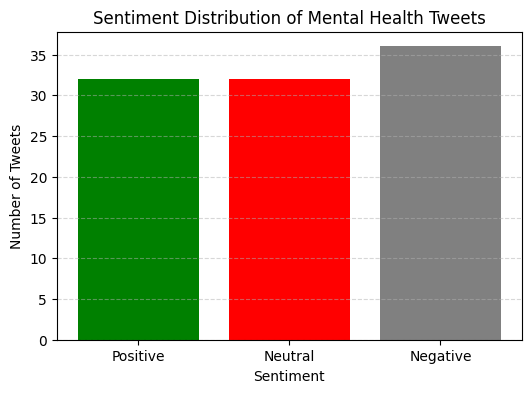

In [23]:
# Bar Chart — Sentiment Distribution
# Plot
plt.figure(figsize=(6,4))
plt.bar(sentiment_pdf["sentiment"], sentiment_pdf["count"], color=["green", "red", "gray"])
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.title("Sentiment Distribution of Mental Health Tweets")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

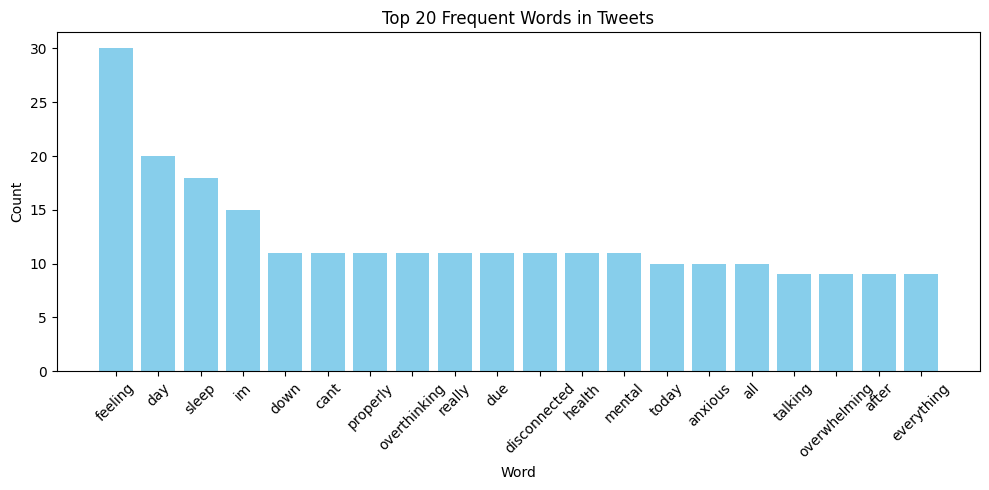

In [24]:
# Top 20 Words Bar Chart
top_words = filtered_words.groupBy("word").count().orderBy("count", ascending=False).limit(20)
top_words_pd = top_words.toPandas()

# Plot word frequency
plt.figure(figsize=(10,5))
plt.bar(top_words_pd["word"], top_words_pd["count"], color="skyblue")
plt.xticks(rotation=45)
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 20 Frequent Words in Tweets")
plt.tight_layout()
plt.show()


In [25]:
# Get sentiment counts into Pandas
sentiment_counts = df_with_sentiment.groupBy("sentiment").count()
sentiment_pdf = sentiment_counts.toPandas()

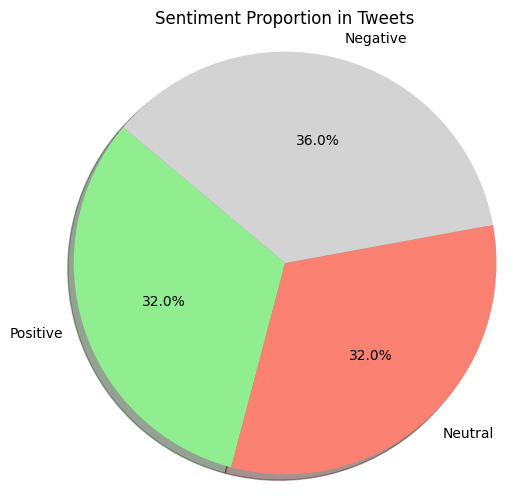

In [26]:
#  Plot Pie Chart
# Colors for each sentiment
colors = ["lightgreen", "salmon", "lightgray"]

# Pie Chart
plt.figure(figsize=(6,6))
plt.pie(
    sentiment_pdf["count"],
    labels=sentiment_pdf["sentiment"],
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    shadow=True
)
plt.title("Sentiment Proportion in Tweets")
plt.axis("equal")  # Equal aspect ratio makes it a perfect circle
plt.show()

**Register DataFrame as SQL Table**

In [27]:
df_with_sentiment.createOrReplaceTempView("mental_health_tweets")

In [28]:
# Sentiment Count
spark.sql("""
    SELECT sentiment, COUNT(*) AS total
    FROM mental_health_tweets
    GROUP BY sentiment
    ORDER BY total DESC
""").show()


+---------+-----+
|sentiment|total|
+---------+-----+
| Negative|   36|
| Positive|   32|
|  Neutral|   32|
+---------+-----+



In [29]:
# Filter Tweets by Sentiment
# Negative Tweets
spark.sql("""
    SELECT tweet_text
    FROM mental_health_tweets
    WHERE sentiment = 'Negative'
    LIMIT 10
""").show(truncate=False)


+-----------------------------------------+
|tweet_text                               |
+-----------------------------------------+
|I'm feeling anxious all day.             |
|Feeling really down and disconnected.    |
|Can't sleep properly due to overthinking.|
|Researching mental health treatments.    |
|Can't sleep properly due to overthinking.|
|Researching mental health treatments.    |
|Can't sleep properly due to overthinking.|
|I'm feeling anxious all day.             |
|Can't sleep properly due to overthinking.|
|Feeling really down and disconnected.    |
+-----------------------------------------+



In [30]:
# Positive Tweets
spark.sql("""
    SELECT tweet_text
    FROM mental_health_tweets
    WHERE sentiment = 'Positive'
    LIMIT 10
""").show(truncate=False)

+-----------------------------------------+
|tweet_text                               |
+-----------------------------------------+
|Feeling better after talking to a friend.|
|Had a peaceful sleep last night.         |
|Feeling better after talking to a friend.|
|Mental health awareness is important.    |
|Feeling better after talking to a friend.|
|Feeling better after talking to a friend.|
|Everything feels overwhelming lately.    |
|Everything feels overwhelming lately.    |
|Mental health awareness is important.    |
|Mental health awareness is important.    |
+-----------------------------------------+

